# Visualize Filters of a CNN using TensorFlow
*Coursera guided project taught by Amit Yadav*

## 1. Download the Model

In [1]:
# Import
import tensorflow as tf
import random
import matplotlib.pyplot as plt

# Print tensorflow version
print('TensorFlow version', tf.__version__)

2023-10-19 11:14:11.765988: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version 2.11.0


In [2]:
# Load VGG16 model
# for more info: https://www.kaggle.com/code/blurredmachine/vggnet-16-architecture-a-complete-guide
model = tf.keras.applications.vgg16.VGG16(
    include_top=False,  # no fully connected final layer
    weights='imagenet', # weights trained on imagenet dataset
    input_shape=(96, 96, 3)
)
model.summary()

2023-10-19 11:14:17.949251: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


58889256/58889256 [==============================] - 11s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                             

## 2. Get Layer Output

In [6]:
# Let's define a function to create submodels and get output of given layers
def get_submodel(layer_name):
  return tf.keras.models.Model(
      model.input,
      model.get_layer(layer_name).output
  )

get_submodel("block1_conv2").summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
_________________________________________________________________


## 3. Image Visualization

In [26]:
# Let's define a function to create a 'random noise' image
def create_image():
  return tf.random.uniform((96, 96, 3), minval=-0.5, maxval=0.5)

# Let's define a function to plot an image normalizing its value between [0, 1]
def plot_image(image, title="random"):
  fig, ax = plt.subplots(figsize=(6, 6))
  image -= tf.math.reduce_min(image) # get all positive values
  image /= tf.math.reduce_max(image) # get values in [0,1]
  ax.imshow(image)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(title)
  plt.show()

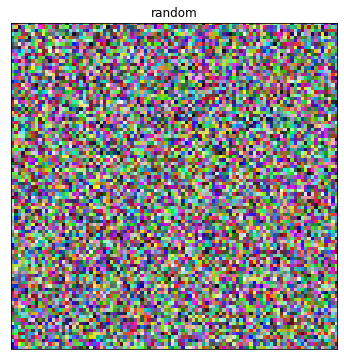

In [27]:
# Create a sample image and plot it
image = create_image()
plot_image(image)

## 4. Training Loop

In [28]:
# Let's write a function to visualize the input that maximally activates
# a given filter. This give us an insight into what the filter is
# looking for in the input image
def visualize_filter(layer_name, f_index=None, iters=50):
  submodel = get_submodel(layer_name)
  num_filters = submodel.output.shape[-1]

  if f_index is None:
    f_index = random.randint(0, num_filters -1)
  assert num_filters > f_index, 'f_index is out of bounds'

  image = create_image()
  verbose_step = int(iters / 10)

  # we look for the image that maximises the output of our submodel
  for i in range(0, iters):
    with tf.GradientTape() as tp:
      tp.watch(image)
      out = submodel(tf.expand_dims(image, axis=0))[:,:,:,f_index]
      loss = tf.math.reduce_mean(out)
    grads = tp.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += grads * 10

    if (i + 1) % verbose_step == 0:
      print(f'Iteration: {i + 1}, Loss: {loss.numpy():.4f}')

  plot_image(image, f'{layer_name}, {f_index}')

## 5. Results

In [29]:
# Print convolutional layers of the model
for layer in model.layers:
  if 'conv' in layer.name:
    print(layer.name)

block1_conv1
block1_conv2
block2_conv1
block2_conv2
block3_conv1
block3_conv2
block3_conv3
block4_conv1
block4_conv2
block4_conv3
block5_conv1
block5_conv2
block5_conv3


Iteration: 5, Loss: 4.0323
Iteration: 10, Loss: 6.7202
Iteration: 15, Loss: 9.3092
Iteration: 20, Loss: 11.8952
Iteration: 25, Loss: 14.4903
Iteration: 30, Loss: 17.0993
Iteration: 35, Loss: 19.7189
Iteration: 40, Loss: 22.3476
Iteration: 45, Loss: 24.9848
Iteration: 50, Loss: 27.6292


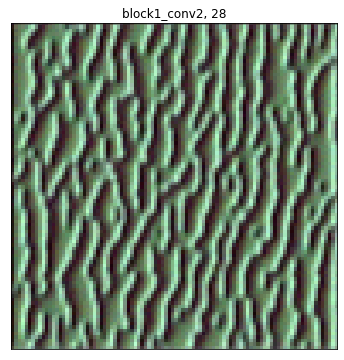

In [31]:
# Let's visualize a sample filter from one of the first layers
visualize_filter("block1_conv2", f_index=28)

Iteration: 5, Loss: 7.6824
Iteration: 10, Loss: 16.4229
Iteration: 15, Loss: 25.8684
Iteration: 20, Loss: 33.7156
Iteration: 25, Loss: 42.2134
Iteration: 30, Loss: 50.5016
Iteration: 35, Loss: 59.3208
Iteration: 40, Loss: 68.3384
Iteration: 45, Loss: 78.1856
Iteration: 50, Loss: 88.7530


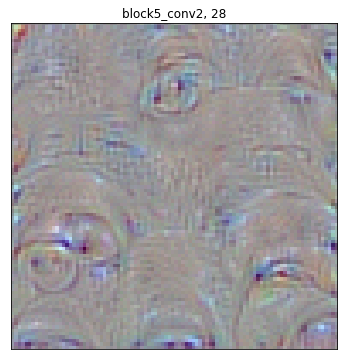

In [32]:
# Let's visualize a sample filter from one of the last layers
visualize_filter("block5_conv2", f_index=28)

We see that the more we go deeper in the network, the more the patterns that activate the filters become complex. This is an expected behaviour of CNNs architectures.